In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
f=open('8046_2010_2019.csv')  
df=pd.read_csv(f)     #讀入股票數據
df=df.dropna(axis=0,how='all')  #删除表中全部為NaN的行
data=np.array(df[['close']])

In [3]:
print(df.shape[0])
time_step=10      #看10天預測第11天
rnn_unit=10       #hidden layer units
batch_size=60     #每一批次訓練多少個unit
input_size=1      #輸入層维度
output_size=1     #輸出層维度
lr=0.0006         #學習率
train_X,train_Y=[],[]   #訓練集
print(len(data)-time_step-1-30)
for i in range(len(data)-time_step-1-30):    
    x=data[i:i+time_step]
    y=data[i+1:i+time_step+1]
    train_X.append(x.tolist())
    train_Y.append(y.tolist())
print(train_X)
print(train_Y)

2372
2331
[[[123.0], [130.5], [134.0], [131.5], [136.0], [141.0], [144.5], [141.0], [143.5], [139.0]], [[130.5], [134.0], [131.5], [136.0], [141.0], [144.5], [141.0], [143.5], [139.0], [139.0]], [[134.0], [131.5], [136.0], [141.0], [144.5], [141.0], [143.5], [139.0], [139.0], [136.0]], [[131.5], [136.0], [141.0], [144.5], [141.0], [143.5], [139.0], [139.0], [136.0], [133.5]], [[136.0], [141.0], [144.5], [141.0], [143.5], [139.0], [139.0], [136.0], [133.5], [139.0]], [[141.0], [144.5], [141.0], [143.5], [139.0], [139.0], [136.0], [133.5], [139.0], [132.5]], [[144.5], [141.0], [143.5], [139.0], [139.0], [136.0], [133.5], [139.0], [132.5], [130.0]], [[141.0], [143.5], [139.0], [139.0], [136.0], [133.5], [139.0], [132.5], [130.0], [124.0]], [[143.5], [139.0], [139.0], [136.0], [133.5], [139.0], [132.5], [130.0], [124.0], [132.5]], [[139.0], [139.0], [136.0], [133.5], [139.0], [132.5], [130.0], [124.0], [132.5], [132.0]], [[139.0], [136.0], [133.5], [139.0], [132.5], [130.0], [124.0], [132.

### 定義神經網路變量

In [4]:
test_x,test_y=[],[]  
for i in range(30):
    x=data[len(data)-30+i-1,np.newaxis]
    test_x.append(x.tolist())
    
for i in range(30):
    y=data[i-30]
    test_y.append(y.tolist())
print(x)        
print(test_x)
print(test_y)

[[41.85]]
[[[41.55]], [[41.7]], [[40.4]], [[37.6]], [[38.65]], [[39.7]], [[39.6]], [[39.5]], [[39.65]], [[39.25]], [[39.8]], [[41.0]], [[41.7]], [[41.75]], [[45.0]], [[44.4]], [[44.25]], [[43.8]], [[42.0]], [[42.5]], [[40.85]], [[40.0]], [[38.25]], [[39.75]], [[38.2]], [[39.8]], [[40.55]], [[40.2]], [[41.1]], [[41.85]]]
[[41.7], [40.4], [37.6], [38.65], [39.7], [39.6], [39.5], [39.65], [39.25], [39.8], [41.0], [41.7], [41.75], [45.0], [44.4], [44.25], [43.8], [42.0], [42.5], [40.85], [40.0], [38.25], [39.75], [38.2], [39.8], [40.55], [40.2], [41.1], [41.85], [41.6]]


In [5]:
print(len(test_x))

30


In [0]:
X=tf.placeholder(tf.float32, [None,None,input_size], name='X')    #每批次輸入網路的tensor
Y=tf.placeholder(tf.float32, [None,None,output_size], name='Y')   #每批次tensor對應的標籤
# keep_prob=tf.placeholder(tf.float32, name='keep_prob')

In [0]:
#輸入層、輸出層權重、偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit]) ,name='w_in'),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]) ,name='w_out')
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit]) ,name='b_in'),
        'out':tf.Variable(tf.constant(0.1,shape=[1]) ,name='b_out')
        }

In [8]:
weights

{'in': <tf.Variable 'w_in:0' shape=(1, 10) dtype=float32_ref>,
 'out': <tf.Variable 'w_out:0' shape=(10, 1) dtype=float32_ref>}

### 定義神經網路變量

In [0]:
def lstm(batch_size, time_step, input_size):      #參數：輸入網路批次數目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要將tensor轉成2维進行計算，計算後的结果作為隱藏層的輸入
    # -1代表的含義是不用我們自己指定這一維的大小，函式會自動計算，但列表中只能存在一個-1.
    
    input_rnn=tf.nn.relu(tf.matmul(input,w_in)+b_in)  #hidden layer
    print(input)
    print(input_rnn)
    input_rnn=tf.nn.dropout(input_rnn, keep_prob=0.5)
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #將tensor轉成3维，作為lstm cell的輸入
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    mlstm_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([cell]*3, state_is_tuple = True)  #建立多層的LSTM
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)  
    #output_rnn是紀錄lstm每個輸出節點的结果，final_states是最後一個cell的结果
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作為輸出層的輸入
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    print(input_rnn)
    print(w_in)
    return pred,final_states

### 訓練模型

In [10]:
def train_lstm():
    global batch_size
    pred,_=lstm(batch_size, time_step, input_size)
    print(pred)
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))  
    #loss function:MSE(mean square error)
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(1000):
            step=0
            start=0
            end=start+batch_size
            while(end<len(train_X)):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_X[start:end],Y:train_Y[start:end]})
                start+=batch_size
                end=start+batch_size
                #每50步保存一次参数
                if step%1==0 :
                    print(i,step,loss_)
                    print("保存模型：",saver.save(sess,'stock.model2'))
                step+=1            
with tf.variable_scope('train',reuse=tf.AUTO_REUSE):
    train_lstm()

Streaming output truncated to the last 5000 lines.
保存模型： stock.model2
934 9 40.688873
保存模型： stock.model2
934 10 21.14052
保存模型： stock.model2
934 11 15.523917
保存模型： stock.model2
934 12 5.078175
保存模型： stock.model2
934 13 4.9560246
保存模型： stock.model2
934 14 10.929027
保存模型： stock.model2
934 15 9.352458
保存模型： stock.model2
934 16 4.271178
保存模型： stock.model2
934 17 10.488952
保存模型： stock.model2
934 18 21.865936
保存模型： stock.model2
934 19 17.324312
保存模型： stock.model2
934 20 13.230738
保存模型： stock.model2
934 21 22.306744
保存模型： stock.model2
934 22 14.752386
保存模型： stock.model2
934 23 10.210288
保存模型： stock.model2
934 24 5.65753
保存模型： stock.model2
934 25 4.372004
保存模型： stock.model2
934 26 6.5052876
保存模型： stock.model2
934 27 13.103167
保存模型： stock.model2
934 28 23.373549
保存模型： stock.model2
934 29 13.789958
保存模型： stock.model2
934 30 15.647985
保存模型： stock.model2
934 31 21.97607
保存模型： stock.model2
934 32 10.505402
保存模型： stock.model2
934 33 9.225363
保存模型： stock.model2
934 34 9.33269
保存模型： stock.model2
934 35

### 預測模型

In [0]:
def prediction():
    pred1,_=lstm(1,1,1)      #預測時只輸入[1,time_step,input_size]的測試資料
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #參數恢復
        module_file = tf.train.latest_checkpoint('')
        saver.restore(sess, module_file) 
        print(test_x)
        test_predict=[]
        
        #得到預測結果
        for i in range(len(test_x)):
            prob=sess.run(pred1,feed_dict={X:[test_x[i]]})   
            predict=prob.reshape((-1))
            test_predict.extend(predict)
            
        
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='r')
        plt.plot(list(range(len(test_y))), test_y,  color='b')
        plt.show()
        
        acc = np.sum(np.abs(list(test_y[i] - test_predict[i] for i in range(len(test_y)))))/len(test_y)
        print(acc)
   

        c = {"real" : test_y,"predict" : test_predict}
        test = pd.DataFrame(c)
        #test=test.T
        print(test)

Tensor("train_1/Reshape:0", shape=(?, 1), dtype=float32)
Tensor("train_1/Relu:0", shape=(?, 10), dtype=float32)
Tensor("train_1/Reshape_1:0", shape=(?, 1, 10), dtype=float32)
<tf.Variable 'w_in:0' shape=(1, 10) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from stock.model2
[[[41.55]], [[41.7]], [[40.4]], [[37.6]], [[38.65]], [[39.7]], [[39.6]], [[39.5]], [[39.65]], [[39.25]], [[39.8]], [[41.0]], [[41.7]], [[41.75]], [[45.0]], [[44.4]], [[44.25]], [[43.8]], [[42.0]], [[42.5]], [[40.85]], [[40.0]], [[38.25]], [[39.75]], [[38.2]], [[39.8]], [[40.55]], [[40.2]], [[41.1]], [[41.85]]]


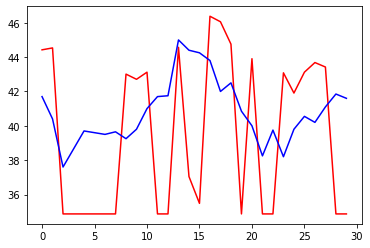

4.25002316792806
       real    predict
0    [41.7]  44.423649
1    [40.4]  44.533924
2    [37.6]  34.870071
3   [38.65]  34.870071
4    [39.7]  34.870071
5    [39.6]  34.870071
6    [39.5]  34.870071
7   [39.65]  34.870071
8   [39.25]  43.009308
9    [39.8]  42.707336
10   [41.0]  43.122158
11   [41.7]  34.870071
12  [41.75]  34.870071
13   [45.0]  44.570644
14   [44.4]  37.045288
15  [44.25]  35.484753
16   [43.8]  46.378784
17   [42.0]  46.057270
18   [42.5]  44.753887
19  [40.85]  34.870071
20   [40.0]  43.906368
21  [38.25]  34.870071
22  [39.75]  34.870071
23   [38.2]  43.084564
24   [39.8]  41.907482
25  [40.55]  43.122158
26   [40.2]  43.683331
27   [41.1]  43.422089
28  [41.85]  34.870071
29   [41.6]  34.870071


In [12]:
with tf.variable_scope('train',reuse=True):
    prediction() 